# Minimizing Risk in Peer-to-Peer Lending
Peer-to-peer lending allows everyone to invest in loans and earn interest, just like a bank does. Anyone can get started with as little as a $25 dollar investment. Loans are underwritten and graded by risk level by the hosting platform (i.e. Lending Club, Prosper, Upstart, etc). Just like with any investment the higher the risk (higher default rates), the higher the reward (return on investment). Our aim with this project is to make a model that lowers the risk of the highest upside loans by lowering loan defaults. In short, we want a model that is lower risk, but maintains high reward. Accomplishing this will boost investor's return on investment. 

# Opening and Exploring the Data
Fortunately peer-to-peer lending sites like [Lending Club](https://lendingclub.com) share their loan data in order to show transparency for potential investors. They share many financial details about the borrow so investors can make better decisions about which loans to invest in. Borrower's privacy is protected by removing their names, address, and last 2 digits of zipcode. However, many intimate details like number of bankruptcies, tax liens, annual income, and credit score are a part of the dataset. 

For this project I will be using all of the loans issued from Lending Club for 2014. The data is available to anyone with a lending club account. Both an account and the data are free. I have downloaded and copied the 2014 loan data from Lending Club [here](https://drive.google.com/file/d/1FY2kMq_uOTrXoFb5YGwDVwM4gvdUPTlC/view?usp=sharing). Lending Club data goes as far back as 2007 and as recent as the 2nd quarter of 2020. This accounts for over 3 million loans.

## Why focus only on loans from 2014?
Computational power and speed are a problem for modeling such a large dataset. Focusing on 1 year allowed us to cut our data set down 235,000 loans. From there will focusing on a riskier subset of loans (about 6,500), which is much better for our cpu limitations. Additionaly we will be focusing our analysis on loans that have been paid in full or charged off (defaulted). Loan Terms are 3 years (36 months) and 5 years (60 months). So choosing loans issued in 2014 gave us one of the most recent samples where all loan due dates had passed. 


In [1]:
# Set up environment
import math
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

# supress warnings (warnings do not prevent the code from executing)
import warnings
warnings.filterwarnings("ignore")

In [2]:
loans_2014 = pd.read_csv(r'/Users/tarrantcarter/Dropbox/Data Science/Thinkful/Thinkful Data Science Projects/Supervised Learning/archive/lc_2014.csv')

loans = loans_2014

loans.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,36805548,NaN,10400.0,10400.0,10400.0,36 months,6.99%,321.08,A,A3,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,38098114,NaN,15000.0,15000.0,15000.0,60 months,12.39%,336.64,C,C1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,37822187,NaN,9600.0,9600.0,9600.0,36 months,13.66%,326.53,C,C3,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,37612354,NaN,12800.0,12800.0,12800.0,60 months,17.14%,319.08,D,D4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,37842129,NaN,21425.0,21425.0,21425.0,60 months,15.59%,516.36,D,D1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235631 entries, 0 to 235630
Columns: 150 entries, id to settlement_term
dtypes: float64(113), object(37)
memory usage: 269.7+ MB


In [4]:
pd.options.display.max_rows = 1000

loans.head().T

,0,1,2,3,4
id,36805548,38098114,37822187,37612354,37842129
member_id,NaN,NaN,NaN,NaN,NaN
loan_amnt,10400,15000,9600,12800,21425
funded_amnt,10400,15000,9600,12800,21425
funded_amnt_inv,10400,15000,9600,12800,21425
term,36 months,60 months,36 months,60 months,60 months
int_rate,6.99%,12.39%,13.66%,17.14%,15.59%
installment,321.08,336.64,326.53,319.08,516.36
grade,A,C,C,D,D
sub_grade,A3,C1,C3,D4,D1


There are over 235 thousand loans and 151 columns in the loans dataset. There are many abbreviated columns where the abbreviation's meaning doesn't seem obvious. Fortunately Lending Club has a [downloadable data dictionary](https://resources.lendingclub.com/LCDataDictionary.xlsx) that will help decipher each column. 

With initial inspection we see useful columns like fico_range_high, mths_since_recent_bc_dlq (months since a recent credit card deliquency), dti (debt to income ratio) seem like useful variables. Columns like policy_code and deferral_term don't seem immediately useful. We will explore each column in more detail later. 

# Data Cleaning
## Dealing with Missing Values

In [5]:
def missingness_summary(df,sort,print_log=True):
    percentage_null = df.isnull().sum()*100/df.isnull().count()
    if sort == 'ascending':
        return percentage_null.sort_values()
    elif sort == 'descending':
        return percentage_null.sort_values(ascending=False)
    else:
        return percentage_null
 

In [6]:
missing = missingness_summary(loans,'descending')
missing

il_util                                       100.000000
dti_joint                                     100.000000
sec_app_mort_acc                              100.000000
sec_app_open_acc                              100.000000
sec_app_revol_util                            100.000000
sec_app_open_act_il                           100.000000
sec_app_num_rev_accts                         100.000000
sec_app_chargeoff_within_12_mths              100.000000
sec_app_collections_12_mths_ex_med            100.000000
sec_app_mths_since_last_major_derog           100.000000
sec_app_fico_range_high                       100.000000
sec_app_fico_range_low                        100.000000
revol_bal_joint                               100.000000
total_bal_il                                  100.000000
annual_inc_joint                              100.000000
verification_status_joint                     100.000000
sec_app_earliest_cr_line                      100.000000
open_acc_6m                    

In [7]:
loans2 = loans.loc[:, pd.notnull(loans).sum()>len(loans)*.8]
missingness_summary(loans2,'descending')

mths_since_recent_inq         9.206768
emp_title                     5.618106
emp_length                    5.101621
num_tl_120dpd_2m              3.336573
mo_sin_old_il_acct            3.044167
bc_util                       1.108937
percent_bc_gt_75              1.086020
bc_open_to_buy                1.038488
mths_since_recent_bc          0.954034
last_pymnt_d                  0.061537
revol_util                    0.053898
last_credit_pull_d            0.011883
avg_cur_bal                   0.003395
hardship_flag                 0.001273
sub_grade                     0.000849
total_acc                     0.000849
funded_amnt_inv               0.000849
inq_last_6mths                0.000849
open_acc                      0.000849
pub_rec                       0.000849
revol_bal                     0.000849
funded_amnt                   0.000849
initial_list_status           0.000849
fico_range_high               0.000849
out_prncp                     0.000849
out_prncp_inv            

In [8]:
loans2.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'a

In [9]:
numeric_columns = loans2.select_dtypes(np.number)
object_columns = loans2.select_dtypes('object')
numeric_columns.head().T

,0,1,2,3,4
loan_amnt,10400.0000,15000.00,9600.00,12800.00000,21425.00
funded_amnt,10400.0000,15000.00,9600.00,12800.00000,21425.00
funded_amnt_inv,10400.0000,15000.00,9600.00,12800.00000,21425.00
installment,321.0800,336.64,326.53,319.08000,516.36
annual_inc,58000.0000,78000.00,69000.00,125000.00000,63800.00
dti,14.9200,12.03,25.81,8.31000,18.49
delinq_2yrs,0.0000,0.00,0.00,1.00000,0.00
fico_range_low,710.0000,750.00,680.00,665.00000,685.00
fico_range_high,714.0000,754.00,684.00,669.00000,689.00
inq_last_6mths,2.0000,0.00,0.00,0.00000,0.00


In [10]:
object_columns.head().T

,0,1,2,3,4
id,36805548,38098114,37822187,37612354,37842129
term,36 months,60 months,36 months,60 months,60 months
int_rate,6.99%,12.39%,13.66%,17.14%,15.59%
grade,A,C,C,D,D
sub_grade,A3,C1,C3,D4,D1
emp_title,Truck Driver Delivery Personel,MANAGEMENT,Admin Specialist,Senior Sales Professional,Programming Analysis Supervisor
emp_length,8 years,10+ years,10+ years,10+ years,6 years
home_ownership,MORTGAGE,RENT,RENT,MORTGAGE,RENT
verification_status,Not Verified,Source Verified,Source Verified,Verified,Source Verified
issue_d,Dec-14,Dec-14,Dec-14,Dec-14,Dec-14


In [11]:
loans3 = loans2.dropna()
loans3.isnull().sum()

id                            0
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_title                     0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
pymnt_plan                    0
url                           0
purpose                       0
title                         0
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
fico_range_low                0
fico_range_high               0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_ut

## Removing loan grades irrelevant to our analysis
We will be focusing our analysis on Grade F and Grade G loans. So we will remove all other grades of loans from our dataset.  

Initially we ran our models with the majority class labeled 1 and the minority 0. No models made any predictions in the minority class. So we will be inverting our majority class (good loans) and labeling it 0. That way we can focus on the minority class (bad loans) recall, because false positives of the majority class (loans our model encourages us to invest in but default) carry such a high cost for investors if they default. This is what we are hoping to minimize with our model. We want to minimize the investment in bad loans our models predicts will be good loans. Hopefully by focusing on minority class recall this will also help increase majority class precision by reducing fewer false positives for good loans. 

In [12]:
loans3.loan_status.value_counts()

Fully Paid     154422
Charged Off     33511
Default             1
Name: loan_status, dtype: int64

In [13]:
loans3['loan_status'] = loans3['loan_status'].replace(['Fully Paid'], 0)
loans3['loan_status'] = loans3['loan_status'].replace(['Default','Charged Off'], 1)                                                                   

In [14]:
loans3.loan_status.value_counts()

0    154422
1     33512
Name: loan_status, dtype: int64

In [15]:
# function to help calculate the net interest return rates by grade
def interest_weights(grade):
  df = loans3[(loans3['grade'] == grade.upper())]
  bad_loans = df.loc[df['loan_status'] == 1, 'total_pymnt_inv']
  good_loans = df.loc[df['loan_status'] == 0, 'total_pymnt_inv']
  gross_good_loans = good_loans.sum()/len(good_loans)
  gross_bad_loans = bad_loans.sum()/len(bad_loans)
  bad_loans = df.loc[df['loan_status'] == 1, 'loan_amnt']
  good_loans = df.loc[df['loan_status'] == 0, 'loan_amnt']  
  cost_good_loans = good_loans.sum()/len(good_loans)
  cost_bad_loans = bad_loans.sum()/len(bad_loans)
  net_profit_good_loans = gross_good_loans - cost_good_loans
  net_profit_bad_loans = gross_bad_loans - cost_bad_loans
  good_loans = len(good_loans)
  bad_loans = len(bad_loans)  
  good_ratio = good_loans/(good_loans+bad_loans)
  bad_ratio = bad_loans/(bad_loans+good_loans)
  weighted_profit = (good_ratio * net_profit_good_loans) + (bad_ratio * net_profit_bad_loans)
  weighted_cost = (good_ratio * cost_good_loans) + (bad_ratio * cost_bad_loans)
  return f'Net Interest Rate {grade} Loans: {round(100 * (weighted_profit/(weighted_profit + weighted_cost)),2)}%'

In [16]:
print(interest_weights('A'))
print(interest_weights('B'))
print(interest_weights('C'))
print(interest_weights('D'))
print(interest_weights('E'))
print(interest_weights('F'))
print(interest_weights('G'))

Net Interest Rate A Loans: 7.17%
Net Interest Rate B Loans: 9.87%
Net Interest Rate C Loans: 11.3%
Net Interest Rate D Loans: 12.46%
Net Interest Rate E Loans: 11.55%
Net Interest Rate F Loans: 11.88%
Net Interest Rate G Loans: 8.97%


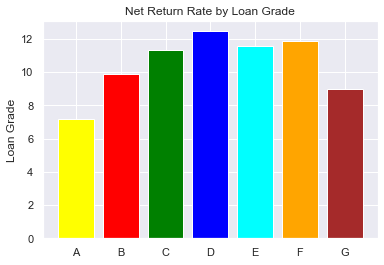

In [17]:
height = [7.17,9.87,11.3,12.46,11.55,11.88,8.97]
bars = ('A','B','C','D','E','F','G')
y_pos = np.arange(len(bars))
 
plt.bar(y_pos, height,color=['yellow', 'red', 'green', 'blue', 'cyan','orange','brown'])
plt.xticks(y_pos, bars)

plt.title('Net Return Rate by Loan Grade')
plt.ylabel('Interest Rate')
plt.ylabel('Loan Grade')
plt.show()

In [18]:
loans3['grade'].value_counts()

C    52193
B    49235
D    34832
A    28622
E    16470
F     5139
G     1443
Name: grade, dtype: int64

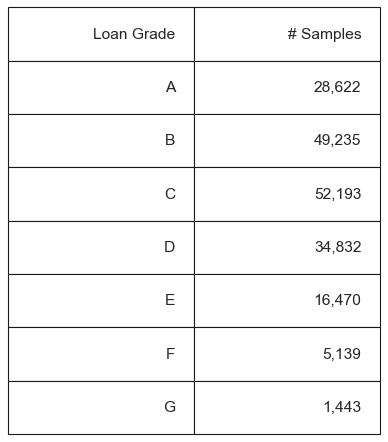

In [19]:
fig = plt.figure(dpi=80)
ax = fig.add_subplot(1,1,1)
table_data=[
    ["Loan Grade", '# Samples'],
    ["A", '28,622'],
    ["B", '49,235'],
    ["C", '52,193'],
    ["D", '34,832'],
    ["E", '16,470'],
    ["F", '5,139'],
    ["G", '1,443']
]
table = ax.table(cellText=table_data, loc='center')
table.set_fontsize(14)
table.scale(1,4)
ax.axis('off')
plt.show()

In [20]:
loans3['loan_status'].value_counts()

0    154422
1     33512
Name: loan_status, dtype: int64

In [21]:
loans4 = loans3[(loans3['grade'] == 'F')| (loans3['grade']=='G')]

In [22]:
loans4.loan_status.value_counts()

0    4065
1    2517
Name: loan_status, dtype: int64

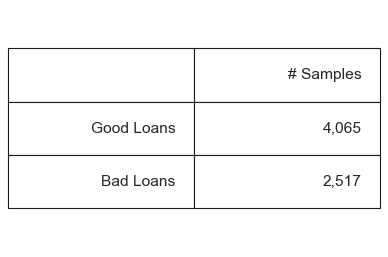

In [23]:
fig = plt.figure(dpi=80)
ax = fig.add_subplot(1,1,1)
table_data=[
    ["", '# Samples'],
    ["Good Loans", '4,065'],
    ["Bad Loans", '2,517'],
]
table = ax.table(cellText=table_data, loc='center')
table.set_fontsize(14)
table.scale(1,4)
ax.axis('off')
plt.show()

In [24]:
bad_loans = loans4.loc[loans4['loan_status'] == 1, 'total_pymnt_inv']
good_loans = loans4.loc[loans4['loan_status'] == 0, 'total_pymnt_inv']

gross_good_loans = good_loans.sum()/len(good_loans)
gross_bad_loans = bad_loans.sum()/len(bad_loans)

print("Average Gross Good Loans: ", gross_good_loans)
print("Average Gross Bad Loans: ", gross_bad_loans)

Average Gross Good Loans:  24920.510255842557
Average Gross Bad Loans:  12391.72801748113


In [25]:
bad_loans = loans4.loc[loans4['loan_status'] == 1, 'loan_amnt']
good_loans = loans4.loc[loans4['loan_status'] == 0, 'loan_amnt']

cost_good_loans = good_loans.sum()/len(good_loans)
cost_bad_loans = bad_loans.sum()/len(bad_loans)

print("Average Loan Cost Good Loans: ", cost_good_loans)
print("Average Loan Cost Bad Loans: ", cost_bad_loans)

Average Loan Cost Good Loans:  17369.10209102091
Average Loan Cost Bad Loans:  18702.90027810886


In [26]:
net_profit_good_loans = gross_good_loans - cost_good_loans
net_profit_bad_loans = gross_bad_loans - cost_bad_loans

print("Average Net Profit Good Loans: ", net_profit_good_loans)
print("Average Net Profit Bad Loans: ", net_profit_bad_loans)

Average Net Profit Good Loans:  7551.408164821645
Average Net Profit Bad Loans:  -6311.172260627731


In [27]:
def average_interest(good_loans,bad_loans):  
  good_ratio = good_loans/(good_loans+bad_loans)
  bad_ratio = bad_loans/(bad_loans+good_loans)
  weighted_profit = (good_ratio * net_profit_good_loans) + (bad_ratio * net_profit_bad_loans)
  weighted_cost = (good_ratio * cost_good_loans) + (bad_ratio * cost_bad_loans)
  average_int = round(100 * weighted_profit/(weighted_profit + weighted_cost),2)  
  return average_int

In [28]:
# interest rate for all E & F loans
all_loans_interest = average_interest(loans4.loan_status.value_counts()[0],loans4.loan_status.value_counts()[1])
f'{all_loans_interest}%'

'11.18%'

# Feature Engineering
## Removing Unavailable Columns
Since we are looking at the loans after their term completion, there are some columns that were not available at the time we could have invested. Ad hoc columns like recovery_fees, last_fico_range_high will be removed. In order to help with this removal we will consult the [data dictionary](https://resources.lendingclub.com/LCDataDictionary.xlsx) and remove columns that apply only to the 'LoanStats' sheet and keep ones related to the 'browseNotes'. That way we will be analysing the same information investors had at the time of potential investment. 

In [29]:
#drop ad hoc categories
loans5 = loans4.drop(['recoveries','collection_recovery_fee','last_pymnt_amnt','total_rec_prncp','out_prncp_inv',
                      'out_prncp','total_pymnt','total_pymnt_inv','last_fico_range_low',
                     'last_fico_range_high', 'total_rec_late_fee','total_rec_int'],axis=1)

## Multicollinearity
Next we will remove features that correlate 0.75 or higher with each other. We are doing this because even though most of our models can handle mutlicollinearity well, high mutlicollinearity will impact the meaningfulness of our feature importances for those models.

In [30]:
numeric_columns = loans5.select_dtypes(np.number)

In [31]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(numeric_columns, 20))

Top Absolute Correlations
loan_amnt          funded_amnt                   1.000000
fico_range_low     fico_range_high               1.000000
funded_amnt        funded_amnt_inv               0.999999
loan_amnt          funded_amnt_inv               0.999999
num_actv_rev_tl    num_rev_tl_bal_gt_0           0.999490
open_acc           num_sats                      0.999104
tot_cur_bal        tot_hi_cred_lim               0.991049
funded_amnt_inv    installment                   0.974268
funded_amnt        installment                   0.974247
loan_amnt          installment                   0.974247
revol_bal          total_rev_hi_lim              0.910348
num_actv_bc_tl     num_bc_sats                   0.900808
total_bal_ex_mort  total_il_high_credit_limit    0.879470
bc_util            percent_bc_gt_75              0.849053
num_op_rev_tl      num_rev_tl_bal_gt_0           0.847115
num_actv_rev_tl    num_op_rev_tl                 0.846674
num_bc_tl          num_rev_accts              

In [32]:
loans6 = loans5.drop(['fico_range_high','funded_amnt','installment','funded_amnt_inv','num_rev_tl_bal_gt_0','num_sats','tot_hi_cred_lim',
                     'total_rev_hi_lim'],axis=1)

In [33]:
numeric_columns_2 = loans6.select_dtypes(np.number)
print("Top Absolute Correlations")
print(get_top_abs_correlations(numeric_columns_2, 10))

Top Absolute Correlations
num_actv_bc_tl     num_bc_sats                   0.900808
total_bal_ex_mort  total_il_high_credit_limit    0.879470
bc_util            percent_bc_gt_75              0.849053
num_actv_rev_tl    num_op_rev_tl                 0.846674
num_bc_tl          num_rev_accts                 0.843754
tot_cur_bal        avg_cur_bal                   0.840236
open_acc           num_op_rev_tl                 0.835319
acc_now_delinq     num_tl_30dpd                  0.827383
pub_rec            tax_liens                     0.810480
num_actv_bc_tl     num_actv_rev_tl               0.803680
dtype: float64


In [34]:
loans7 = loans6.drop(['num_bc_sats','total_il_high_credit_limit','avg_cur_bal','num_op_rev_tl','num_bc_tl',
                      'percent_bc_gt_75','num_op_rev_tl','num_tl_30dpd','num_actv_bc_tl','num_rev_accts',
                      'tax_liens'],axis=1)

numeric_columns_3 = loans7.select_dtypes(np.number)
print("Top Absolute Correlations")
print(get_top_abs_correlations(numeric_columns_3, 10))

Top Absolute Correlations
acc_open_past_24mths   num_tl_op_past_12m       0.717784
open_acc               num_actv_rev_tl          0.717465
                       total_acc                0.702942
total_acc              num_il_tl                0.674457
bc_open_to_buy         total_bc_limit           0.662755
delinq_2yrs            num_tl_90g_dpd_24m       0.642101
revol_bal              total_bc_limit           0.588275
num_accts_ever_120_pd  pct_tl_nvr_dlq           0.588147
delinq_amnt            num_tl_120dpd_2m         0.569232
inq_last_6mths         mths_since_recent_inq    0.562278
dtype: float64


## Encoding Features

In [35]:
loans7.describe(include='O').T

,count,unique,top,freq
id,6582,6582,10616822,1
term,6582,2,60 months,4960
int_rate,6582,14,23.43%,1242
grade,6582,2,F,5139
sub_grade,6582,10,F1,1582
emp_title,6582,4114,Teacher,124
emp_length,6582,11,10+ years,2396
home_ownership,6582,3,MORTGAGE,3233
verification_status,6582,3,Source Verified,2992
issue_d,6582,12,Oct-14,944


In [36]:
#dropping categorical variables that have too few meaningful categories
loans8 = loans7.drop(['id','grade','emp_title','issue_d','url','title','zip_code','addr_state',
                      'earliest_cr_line','last_pymnt_d','last_credit_pull_d','debt_settlement_flag','policy_code',
                      'int_rate','verification_status','issue_d','revol_util','application_type','hardship_flag'
                     ],axis=1)

In [37]:
loans8.emp_length.value_counts()

10+ years    2396
2 years       596
3 years       515
< 1 year      511
1 year        403
7 years       382
4 years       379
6 years       375
8 years       375
5 years       364
9 years       286
Name: emp_length, dtype: int64

In [38]:
# ordinal encode employment length
emp_mapping = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10,
}

loans8['emp_length'] = loans8['emp_length'].map(emp_mapping)

In [39]:
loans8.emp_length.value_counts()

10    2396
2      596
3      515
0      511
1      403
7      382
4      379
6      375
8      375
5      364
9      286
Name: emp_length, dtype: int64

In [40]:
loans8.home_ownership.value_counts()

MORTGAGE    3233
RENT        2675
OWN          674
Name: home_ownership, dtype: int64

In [41]:
loans8['home_ownership'] = loans8['home_ownership'].replace(['ANY','NONE','OTHER'], np.nan)

In [42]:
loans9 = loans8.dropna()

In [43]:
loans9.home_ownership.value_counts()

MORTGAGE    3233
RENT        2675
OWN          674
Name: home_ownership, dtype: int64

# Preliminary Models
We will try 3 untuned models and see which one improves our bad loan recall the most and also reduces the good loan false positives the most. We will use a logistic regression, svc, and an ada boosting model with a decision tree classifier. The one with the best bad loan recall and best reduction of good loan false positives will be tuned to find the optimal parameters in the next step. 

In [44]:
X = loans9.drop('loan_status', axis=1)
X = pd.get_dummies(X,drop_first=True)
y = loans9['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=412)

In [45]:
X.shape

(6582, 62)

In [46]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()

X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

In [47]:
logit = LogisticRegression(max_iter=1000)

logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
print("Train score: ",logit.score(X_train, y_train))
print("Test score: ",logit.score(X_test, y_test))

Train score:  0.6334283000949668
Test score:  0.6097190584662111


In [49]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Given a scikit-learn confusion matrix (CM), make a nice plot.

    Arguments
    ---------
    cm:           Confusion matrix from sklearn.metrics.confusion_matrix

    target_names: Given classification classes, such as [0, 1, 2]
                  The class names, for example, ['high', 'medium', 'low']

    title:        The text to display at the top of the matrix

    cmap:         The gradient of the values displayed from matplotlib.pyplot.cm
                  See http://matplotlib.org/examples/color/colormaps_reference.html
                  `plt.get_cmap('jet')` or `plt.cm.Blues`

    normalize:    If `False`, plot the raw numbers
                  If `True`, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # Confusion matrix created by
                                                              # `sklearn.metrics.confusion_matrix`
                          normalize    = True,                # Show proportions
                          target_names = y_labels_vals,       # List of names of the classes
                          title        = best_estimator_name) # Title of graph

    Citation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

              precision    recall  f1-score   support

           0       0.63      0.87      0.73       812
           1       0.48      0.19      0.27       505

    accuracy                           0.61      1317
   macro avg       0.56      0.53      0.50      1317
weighted avg       0.57      0.61      0.56      1317



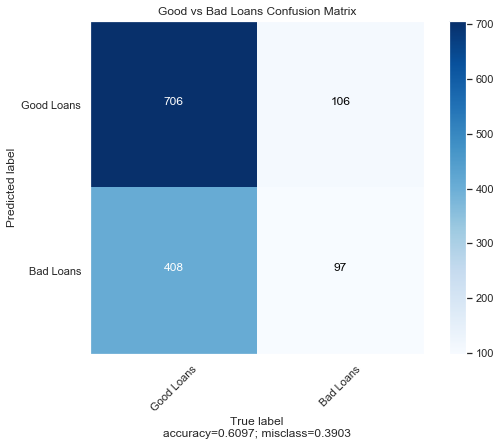

In [50]:
y_pred = logit.predict(X_test)

print(classification_report(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm=confusion, target_names=['Good Loans','Bad Loans'],
                      title = 'Good vs Bad Loans Confusion Matrix',normalize=False)

The logistic regression model makes very few predictions for bad loans and recall is very poor (0.09). It reduces good loan's false positives slightly since good loan precision increases by 0.01. It appears to be underfitting slightly. 

In [51]:
svc = SVC()

svc.fit(X_train, y_train)

print("Train score: ",svc.score(X_train, y_train))
print("Test score: ",svc.score(X_test, y_test))

Train score:  0.7008547008547008
Test score:  0.6036446469248291


              precision    recall  f1-score   support

           0       0.62      0.92      0.74       812
           1       0.42      0.09      0.14       505

    accuracy                           0.60      1317
   macro avg       0.52      0.51      0.44      1317
weighted avg       0.54      0.60      0.51      1317



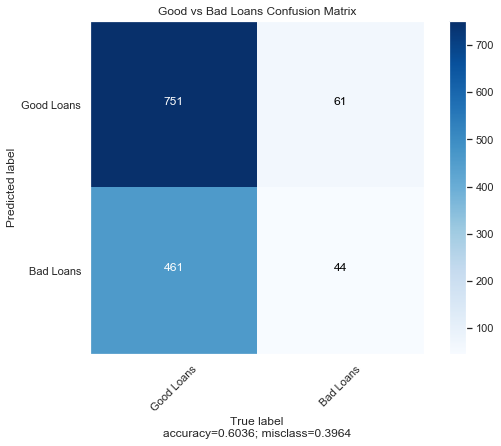

In [52]:
y_pred = svc.predict(X_test)

print(classification_report(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm=confusion, target_names=['Good Loans','Bad Loans'],
                      title = 'Good vs Bad Loans Confusion Matrix',normalize=False)

The SVC model make no predictions for bad loans and not suprisingly recall is 0 and good loan false positives stay the same as average. The train and test split seem to fit closely. 

In [53]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3))

ada.fit(X_train, y_train)

print("Train score: ",ada.score(X_train, y_train))
print("Test score: ",ada.score(X_test, y_test))

Train score:  0.7713200379867047
Test score:  0.5740318906605922


              precision    recall  f1-score   support

           0       0.64      0.70      0.67       812
           1       0.43      0.37      0.40       505

    accuracy                           0.57      1317
   macro avg       0.54      0.54      0.53      1317
weighted avg       0.56      0.57      0.57      1317



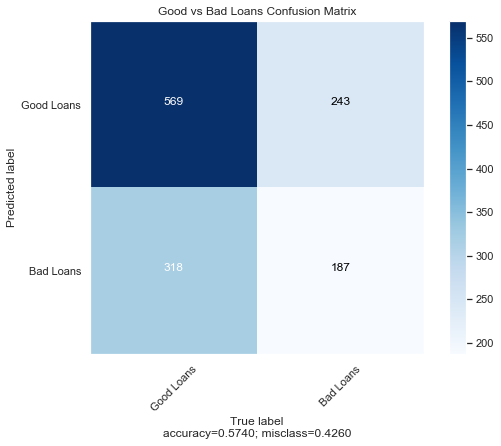

In [54]:
y_pred = ada.predict(X_test)

print(classification_report(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm=confusion, target_names=['Good Loans','Bad Loans'],
                      title = 'Good vs Bad Loans Confusion Matrix',normalize=False)

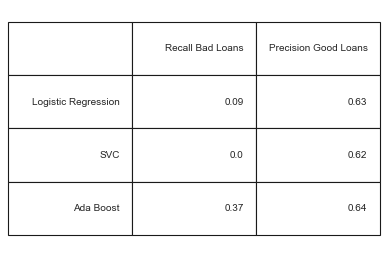

In [55]:
fig = plt.figure(dpi=80)
ax = fig.add_subplot(1,1,1)
table_data=[
    ["", 'Recall Bad Loans', 'Precision Good Loans'],
    ["Logistic Regression",'0.09','0.63'],
    ["SVC", '0.0','0.62'],
    ["Ada Boost", '0.37','0.64']
]
table = ax.table(cellText=table_data, loc='center')
table.set_fontsize(14)
table.scale(1,4)
ax.axis('off')
plt.show()

The ada boosting model with a decision tree classifier overfits a lot more than the other two models and was less accurate. However, it does have the best bad loan recall score (0.37) and it also reduces good loan false positives (good loan precision increase of 0.02) better than any of the three models we tried. It also makes many more predictions for bad loans than any other model did. Next, we will try to improve the ada boosting model by optimizing parameters since it is the best model given our particular circumstances.

# Optimal Model
We will use RandomSearchCV to help tune the learning rate for our ada boosting model. We will change default scoring from accuracy to recall. That way we can hopefully choose bad loans less often. 

Once we have optimized our model, we will highlight our most important features and then compare our model using default improvement rates and interest improvements rates. This will give us a better idea of how effective our model is. 

In [56]:
parameters = {'learning_rate': stats.uniform(0.01, 1)}

ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3))

opt = RandomizedSearchCV(ada, parameters, cv=3, scoring='recall', n_iter=30, n_jobs=2, verbose=True)

opt.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done  90 out of  90 | elapsed:  1.6min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                      class_weight=None,
                                                                                      criterion='gini',
                                                                                      max_depth=3,
                                                                                      max_features=None,
                                                                                      max_leaf_nodes=None,
                                                                                      min_impurity_decrease=0.0,
                                                                                      min_impurity_split=None,
                                            

In [57]:
opt.best_params_

{'learning_rate': 0.8833835202020037}

In [58]:
print("Train score: ",opt.score(X_train, y_train))
print("Test score: ",opt.score(X_test, y_test))

Train score:  0.6003976143141153
Test score:  0.3306930693069307


              precision    recall  f1-score   support

           0       0.63      0.71      0.67       812
           1       0.41      0.33      0.37       505

    accuracy                           0.56      1317
   macro avg       0.52      0.52      0.52      1317
weighted avg       0.55      0.56      0.55      1317



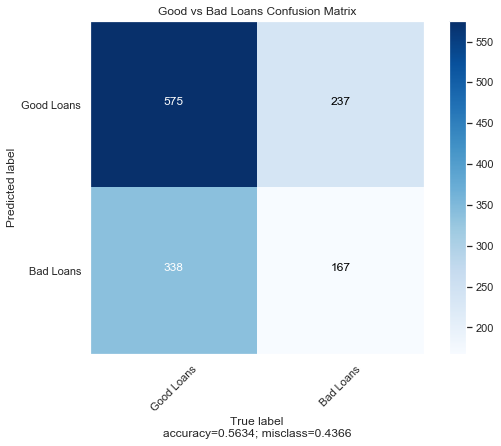

In [59]:
y_pred = opt.predict(X_test)

print(classification_report(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm=confusion, target_names=['Good Loans','Bad Loans'],
                      title = 'Good vs Bad Loans Confusion Matrix',normalize=False)

Overall recall went down slightly by .01, but the model's precision for good loans increased. We see less percentage defaults from the loans our model suggests we invest in than any other model. This is exactly what we want to see. 

In [60]:
def net_interest(good_loans,bad_loans):
  good_ratio = good_loans/(good_loans+bad_loans)
  bad_ratio = bad_loans/(bad_loans+good_loans)
  weighted_profit = (good_ratio * net_profit_good_loans) + (bad_ratio * net_profit_bad_loans)
  weighted_cost = (good_ratio * cost_good_loans) + (bad_ratio * cost_bad_loans)
  model_interest =  round(100 * weighted_profit/(weighted_profit + weighted_cost),2)
  print(f'Default Net Interest: {all_loans_interest}%')
  print(f'Model Net Interest: {model_interest}%')
  print(f'Model Interest Improvement: {round(model_interest - all_loans_interest,2)}%')

In [61]:
good_picks = confusion[0][0]
bad_picks = confusion[1][0]
net_interest(good_picks,bad_picks)

Default Net Interest: 11.18%
Model Net Interest: 11.93%
Model Interest Improvement: 0.75%


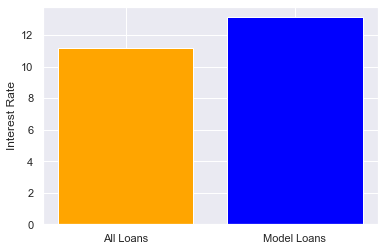

In [62]:
height = [11.18,13.13]
bars = ('All Loans','Model Loans')
y_pos = np.arange(len(bars))
 
plt.bar(y_pos, height,color=['orange', 'blue', ] )
plt.xticks(y_pos, bars)

plt.ylabel('Interest Rate')
plt.show()


In [63]:
#feature = X_train.columns
#importance = opt.best_estimator_.feature_importances_
#df = pd.DataFrame({'Feature': feature, 'Importance': importance})
#df = df.sort_values('Importance', ascending=False)[:10]
#sns.barplot(x='Importance', y='Feature', data=df);

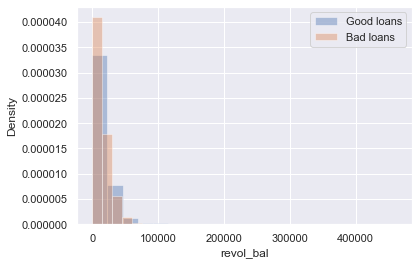

In [64]:
good_loans = X.loc[y == 0, 'revol_bal']
bad_loans = X.loc[y == 1, 'revol_bal']

sns.distplot(good_loans, bins=20, label='Good loans', kde=False, norm_hist=True)
ax = sns.distplot(bad_loans, bins=20, label='Bad loans', kde=False, norm_hist=True)
ax.set_ylabel('Density')
ax.legend();

In [65]:
print(f'Good Loans Avg: {round(good_loans.mean(),0)}')
print(f'Bad Loans Avg: {round(bad_loans.mean(),0)}')

Good Loans Avg: 17104.0
Bad Loans Avg: 15486.0


In [66]:
good_loans = X.loc[y == 0, 'annual_inc']
bad_loans = X.loc[y == 1, 'annual_inc']

print(f'Good Loans Avg: {round(good_loans.mean(),0)}')
print(f'Bad Loans Avg: {round(bad_loans.mean(),0)}')

Good Loans Avg: 75701.0
Bad Loans Avg: 70604.0


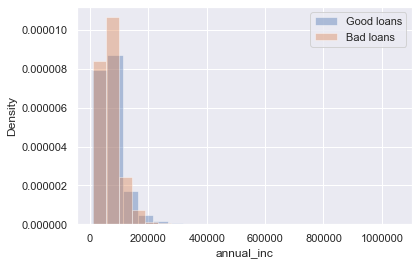

In [67]:
sns.distplot(good_loans, bins=20, label='Good loans', kde=False, norm_hist=True)
ax = sns.distplot(bad_loans, bins=20, label='Bad loans', kde=False, norm_hist=True)
ax.set_ylabel('Density')
ax.legend();

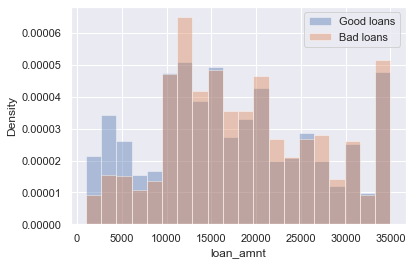

In [68]:
good_loans = X.loc[y == 0, 'loan_amnt']
bad_loans = X.loc[y == 1, 'loan_amnt']

sns.distplot(good_loans, bins=20, label='Good loans', kde=False, norm_hist=True)
ax = sns.distplot(bad_loans, bins=20, label='Bad loans', kde=False, norm_hist=True)
ax.set_ylabel('Density')
ax.legend();

In [69]:
print(f'Good Loans Avg: {round(good_loans.mean(),0)}')
print(f'Bad Loans Avg: {round(bad_loans.mean(),0)}')

Good Loans Avg: 17369.0
Bad Loans Avg: 18703.0


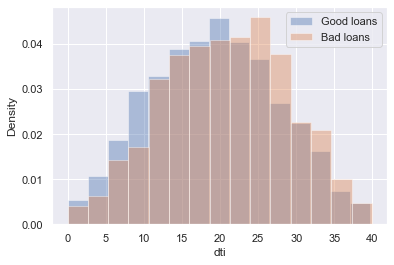

In [70]:
good_loans = X.loc[y == 0, 'dti']
bad_loans = X.loc[y == 1, 'dti']

sns.distplot(good_loans, bins=15, label='Good loans', kde=False, norm_hist=True)
ax = sns.distplot(bad_loans, bins=15, label='Bad loans', kde=False, norm_hist=True)
ax.set_ylabel('Density')
ax.legend();

In [71]:
print(f'Good Loans Avg: {round(good_loans.mean(),0)}')
print(f'Bad Loans Avg: {round(bad_loans.mean(),0)}')

Good Loans Avg: 19.0
Bad Loans Avg: 21.0


In [72]:
def default_rate(good_loans,bad_loans):
  avg_defaults = 100*((loans4.loan_status.value_counts()[1])/(loans4.loan_status.value_counts()[0] + 
                                                         loans4.loan_status.value_counts()[1])) 
  model_defaults = 100 * (bad_picks/(bad_picks+good_picks))
  print(f'All Loans Default Rate: {round(avg_defaults,2)}%')
  print(f'Model Default Rate: {round(model_defaults,2)}%')
  print(f'Model Default Rate Improvement: {round(model_defaults - avg_defaults,2)}%')

In [73]:
default_rate(good_picks,bad_picks)

All Loans Default Rate: 38.24%
Model Default Rate: 37.02%
Model Default Rate Improvement: -1.22%


# Takeaways
The three most important features for our model were revolving balance, loan amount, and debt-to-income ratio. Good loans were more likely to come from people who had higher credit card balances (revolving balance), lower loan amounts, and lower debt-to-income ratios. It doesn't seem suprising that people with lower debt-to-income ratios and smaller loan amounts are more likely to pay off their loans than their counterparts. What is a bit counterintuitive is that people with higher revolving balances (debt) are more likely to pay off their loans than people with lower revolving balances. This happens to be our most important feature and seems to be at odds with the idea that a lower debt to income ratio increases your likelihood of paying your loan in full. How can higher total debt improve our model while a lower debt-to-income ratio improve it as well? One explanation to resolve this tension is that people who paid off their loans also were more likely to have higher incomes. So it shouldn't be suprising that people with higher incomes also have higher credit card balances. This is exactly what we find with our fifth most import feature - annual income. Borrower's in the good loan category tended have higher incomes on average than borrower's from the bad loan category.

Our optimized model reduced loan defaults by 3.21% and increased our rate of return by 1.95%. This model had an overall interest rate of 13.13% compared to the all loans rate of 11.18%. Using this model one could see not only a raw improvement of 1.95%, but also a 17.4% percentage increase in returns on investment. This model allows you to access the loans with the highest payoff while minimizing your risk with defaults. This is perfect for someone just starting out with a very small amount to invest or someone not wanting to risk much money into the peer-to-peer lending market. This model will allow them to minimize risk and maximize returns by the higher quality loans the model predicts. 

## Limitations
All grade F & G loans are very profitable themselves. The combined interest rates for those loans are 11.18%. It is rare to find such a high paying asset class to invest in. If one had the capital it would seem reasonable to invest in as many of the grade F and G loans as possible. 

This data comes from 2014, a year that was very good economically speaking. It would be nice to have a larger sample that included years with much worse economies like 2009 or 2020. So in order to get a more reasonable picture of return rates for these loans, one would have to include times of poorer economic conditions. 

Another concern with this approach is that Lending Club's loan grading process has probably improved since 2014. They can run this analysis just like we did here and they are incentivised to do so (borrowers and lenders pay loan fees). For example, they might have already adjusted for higher credit card balances (revolving balance), lower loan amounts, and lower debt to income ratios. These loans might be graded as lower risk in 2020, so this means lower returns. Grade F & G loans could look very different in 2020 than they did in 2014, because the grading process might have improved.  